# 权重衰减——代码实现

权重衰减是最广泛使用的正则化技术（防止过拟合的技术）之一。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

首先，还是先生成一些人工的数据集。

$$
y = 0.05 + \sum_{i=1}^{d} 0.01x_i + \epsilon \quad \text{其中} \epsilon \sim N(0, 0.01^2)
$$


In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5 
# 特意将训练数据设置的比较小（20，测试多大没关系），这里是为了产生过拟合，（数据越简单模型越复杂，越会过拟合）输入维度有200（模型比较复杂）
true_w = torch.ones((num_inputs, 1)) * 0.01
true_b = 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)

test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化参数：

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs,1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w,b]

权重衰减新增：L2范数惩罚项，即`||w||^2 /2` （没有加入 λ）

In [4]:
def l2_penalty(w): # 惩罚项
    return torch.sum(w.pow(2)) / 2  # w的形状是一个 200x1 的向量

训练代码：

此时的loss函数变为：

$$
\min \ell(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$


In [5]:
def train(lambd): # 调整的参数是 λ，但是python有lambda关键字，这里稍作修改
    w,b = init_params()
    net, loss = lambda X: d2l.linreg(X,w,b), d2l.squared_loss
    num_epochs, lr = 100, 0.003  # 这里保持 epoch * lr = 定值 即可，即一个大了另一个调小点

    # 加入动画表示
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X),y) + lambd * l2_penalty(w) # net(X) 是 y 的预测值
            l.sum().backward()  # 计算梯度
            d2l.sgd([w,b],lr,batch_size) # 梯度下降
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
        
    print('w的L2范数是：', torch.norm(w).item())

我们现在先来试试没有正则化会是什么情况：

w的L2范数是： 12.650177001953125


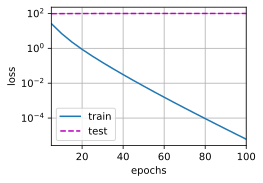

In [6]:
train(lambd=0)  # λ=0，即令惩罚项=0

可以发现，训练集表现非常好，但是测试机loss毫无变化，明显过拟合了。

接下来，我们再看看加入惩罚项的效果：

w的L2范数是： 0.3900603652000427


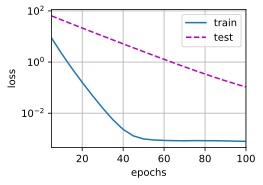

In [7]:
train(lambd=3) # 这里例子比较极端，一般情况λ取 1e-2,1e-3,1e-4 等

可以看到测试集的loss有了明显改善，即过拟合的现象有了明显改善。

# 简洁实现权重衰退

In [8]:
def train_concise(lambd):
    net = nn.Sequential(nn.Linear(num_inputs,1)) # num_inputs个输入，1个输出，所以是全连接层
    for param in net.parameters():
        param.data.normal_() # 遍历所有w和b，以正太分布初始化
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([
        {
        "params": net[0].weight,  # net[0] 指 Sequential 容器中的第一个模型
        "weight_decay": lambd
        }, # 对线性层的权重使用权重衰减
        {
        "params":net[0].bias
        }
        ],lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad(): # 启动自动求导
                trainer.zero_grad()   # 清除之前累积的梯度
                l = loss(net(X),y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item()) # .norm 计算范数  .item将张量转为python数值类型

再来对比下没有/有权重衰退：

w的L2范数： 12.563226699829102


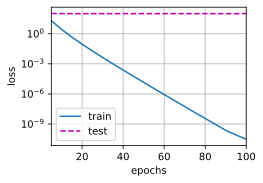

In [9]:
train_concise(0)

w的L2范数： 0.34747445583343506


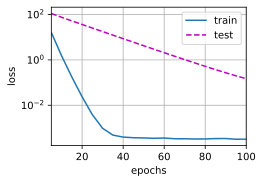

In [10]:
train_concise(3)